In [ ]:

import time
import numpy as np
import cv2
import scipy.special
import matplotlib.pyplot as plt
import os
import csv

from os import listdir
from os.path import isfile, join
import pandas
from scipy import ndimage
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def detect_orange(img):
  img = cv2.resize(img,(184,409))

  hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  hsv = cv2.blur(cv2.cvtColor(img,cv2.COLOR_BGR2HSV),(10,10))

  lower_orange = np.array([10,120,120])
  upper_orange = np.array([20,255,255])
  mask1 = cv2.inRange(hsv, lower_orange, upper_orange)
  #cv2.imshow('mask1',mask1)
  white_val = 0
  for row in range(len(mask1)):
      white_val += sum(mask1[row])/255
  return white_val

In [ ]:
def to_crop_img(image):
  #image = cv2.imread(img_name)


  img = image.copy()
  image = cv2.resize(img,(len(img[0])//5,len(img)//5))

  img = cv2.blur(img,(15,15))

  img = cv2.resize(img,(len(img[0])//5,len(img)//5))

  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Find Canny edges
  #edged = cv2.Canny(img, 25, 250)
  edged = cv2.threshold(img, 125, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]


  contours, hierarchy = cv2.findContours(edged, 
      cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  max_position = 0
  max_value = 0
  for i in range(len(contours)):
      #print(contours[i].shape)
      if(contours[i].shape[0]>max_value):
          max_value = contours[i].shape[0]
          max_position = i
          

  x,y,w,h = cv2.boundingRect(contours[max_position])
  #print(w,' ',h,' ',w/h)
  crop_img = image[y:y+h, x:x+w]

  if(w/h > 0.59):
      rotate = ndimage.rotate(crop_img, 0-((w/h-0.54)*100),cval=205.0)
      img_rotate = cv2.blur(rotate,(1,1))
      img_rotate = cv2.cvtColor(img_rotate, cv2.COLOR_BGR2GRAY)
      rotate_edged = cv2.threshold(img_rotate, 125, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
      #cv2.imshow('img_rotate',rotate_edged)
      contours_rotate, hierarchy_rotate = cv2.findContours(rotate_edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
      max_position_rotate = 0
      max_value_rotate = 0
      for i in range(len(contours_rotate)):
          #print(contours[i].shape)
          if(contours_rotate[i].shape[0]>max_value_rotate):
              max_value_rotate = contours_rotate[i].shape[0]
              max_position_rotate = i
      x_rotate,y_rotate,w_rotate,h_rotate = cv2.boundingRect(contours_rotate[max_position_rotate])
      crop_img_rotate = rotate[y_rotate:y_rotate+h_rotate, x_rotate:x_rotate+w_rotate]
      #print(w_rotate/h_rotate)
      ratio_unclockwise = w_rotate/h_rotate
      if(w_rotate/h_rotate >0.59):
          rotate = ndimage.rotate(crop_img, ((w/h-0.57)*100),cval=205.0)
          img_rotate = cv2.blur(rotate,(1,1))
          img_rotate = cv2.cvtColor(img_rotate, cv2.COLOR_BGR2GRAY)
          rotate_edged = cv2.threshold(img_rotate, 125, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
          #cv2.imshow('img_rotate',rotate_edged)
          contours_rotate, hierarchy_rotate = cv2.findContours(rotate_edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
          max_position_rotate = 0
          max_value_rotate = 0
          for i in range(len(contours_rotate)):
              #print(contours[i].shape)
              if(contours_rotate[i].shape[0]>max_value_rotate):
                  max_value_rotate = contours_rotate[i].shape[0]
                  max_position_rotate = i
          x_rotate,y_rotate,w_rotate,h_rotate = cv2.boundingRect(contours_rotate[max_position_rotate])
          crop_img_rotate = rotate[y_rotate:y_rotate+h_rotate, x_rotate:x_rotate+w_rotate]
          #print(w_rotate/h_rotate)
          ratio_clockwise = w_rotate/h_rotate
          if (ratio_clockwise>ratio_unclockwise):
            rotate = ndimage.rotate(crop_img, 0-((w/h-0.54)*100),cval=205.0)
            img_rotate = cv2.blur(rotate,(1,1))
            img_rotate = cv2.cvtColor(img_rotate, cv2.COLOR_BGR2GRAY)
            rotate_edged = cv2.threshold(img_rotate, 125, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
            #cv2.imshow('img_rotate',rotate_edged)
            contours_rotate, hierarchy_rotate = cv2.findContours(rotate_edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            max_position_rotate = 0
            max_value_rotate = 0
            for i in range(len(contours_rotate)):
                #print(contours[i].shape)
                if(contours_rotate[i].shape[0]>max_value_rotate):
                    max_value_rotate = contours_rotate[i].shape[0]
                    max_position_rotate = i
            x_rotate,y_rotate,w_rotate,h_rotate = cv2.boundingRect(contours_rotate[max_position_rotate])
            crop_img_rotate = rotate[y_rotate:y_rotate+h_rotate, x_rotate:x_rotate+w_rotate]
            #print(w_rotate/h_rotate)
      #cv2.imshow('rotate',crop_img_rotate)
      crop_img = crop_img_rotate #
  return crop_img

In [ ]:
def avg_in_scale(crop_img):
  crop_img = img = cv2.resize(crop_img,(275,512))
  avg_scale_from_crop = []
  count = 0
  for row_line in range(len(crop_img)//30-2):
    for col_line in range(len(crop_img[0])//30-2):
      img_scale = crop_img[(row_line+1)*30:(row_line+1)*30+30, (col_line+1)*30:(col_line+1)*30+30]
      avg_pix = 0
      for row in range(len(img_scale)):
        for col in range(len(img_scale[0])):
          avg_pix += sum(img_scale[row][col])/3
      avg_scale_from_crop.append(avg_pix)
      count+=1
  if (count<105):
    for i in range(105-count):
      avg_scale_from_crop.append(0)
  elif (count>105):
    for i in range(count-105):
      avg_scale_from_crop.pop()

  return np.array(avg_scale_from_crop)

In [ ]:
def detect_yellow(img):
  img = cv2.resize(img,(184,409))

  hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  hsv = cv2.blur(cv2.cvtColor(img,cv2.COLOR_BGR2HSV),(10,10))

  lower_yellow = np.array([18,120,120])
  upper_yellow = np.array([25,255,255])
  mask1 = cv2.inRange(hsv, lower_yellow, upper_yellow)
  #cv2.imshow('mask1',mask1)
  white_val = 0
  for row in range(len(mask1)):
      white_val += sum(mask1[row])/255
  return white_val

In [ ]:
def detect_green(img):
  img = cv2.resize(img,(184,409))

  hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  hsv = cv2.blur(cv2.cvtColor(img,cv2.COLOR_BGR2HSV),(10,10))

  lower_green = np.array([35,120,120])
  upper_green = np.array([55,255,255])
  mask1 = cv2.inRange(hsv, lower_green, upper_green)
  #cv2.imshow('mask1',mask1)
  white_val = 0
  for row in range(len(mask1)):
      white_val += sum(mask1[row])/255
  return white_val

In [ ]:
# neural network class definition
class neuralNetwork :

    # initialise the neural network
    def __init__(self, inputnodes, outputnodes,learningrate,bias) :

        # set number of nodes in each input, hidden, output layer
        self.inodes = inputnodes
        
        self.onodes = outputnodes

        #set weight
        self.w = np.random.normal(0.0, pow(self.onodes, -0.5),(self.onodes, self.inodes))

        # learning rate
        self.lr = learningrate
        self.bias = bias

        # activation function is the sigmoid function
        self.activation_function = lambda x: scipy.special.expit(x)
        #self.derivative_function = lambda x: 1 if x>0 else 0 if x==0 else -1

        self.dw = 0
        pass
   
    

    # train the neural network
    def train(self, inputs_list, targets_list) :
        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        # print('targets = ', targets)

        
        w_dot_input = np.dot(self.w, inputs)
        #print(w_dot_input)
        
        outputs = self.activation_function(w_dot_input+1)
        #print('final_outputs = ', outputs)

        # output layer error is the (target actual)
        output_errors = targets-outputs
        #print('output_errors = ', output_errors)
        
        # update the weights 
        self.dw = self.lr * np.dot(output_errors,np.transpose(inputs))
        #print(np.multiply( output_errors,self.derivative_function(outputs) ))
        #print(output_errors*self.derivative_function(outputs))
        #self.dw = self.lr * np.dot(output_errors,np.transpose(inputs))#+(0.9*self.dw)
        #self.dw = self.lr * np.dot( np.multiply( output_errors,self.derivative_function(outputs) ) ,np.transpose(inputs))+(0.9*self.dw)
        self.dw = self.lr * np.dot((output_errors*outputs * (1.0-outputs)),np.transpose(inputs)) +(0.9*self.dw)
        self.w += self.dw
        self.bias +=  self.lr *sum(output_errors)
        


        # print("*********")
        pass

    # query the neural network
    def query(self, inputs_list) :

        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T


        output = np.dot(self.w, inputs)

        # calculate the signals emerging 
        final_outputs = self.activation_function(output)

        return final_outputs
    
   
    # def write_weight(self) :
    #     f = open('who.txt','w',encoding='utf-8')
    #     f.write(str(self.who))
    #     f.close()
    #     f = open('wih.txt','w',encoding='utf-8')
    #     f.write(str(self.wih))
    #     f.close()
    #     print('already write!! ')
        

In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

!unzip drive/"My Drive"/korat_sauce/train_data_use_color2.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  drive/My Drive/korat_sauce/train_data_use_color2.zip
   creating: train_data/
  inflating: train_data/maeyupa.0.jpg  
  inflating: train_data/maeyupa.1.jpg  
  inflating: train_data/maeyupa.100.jpg  
  inflating: train_data/maeyupa.101.jpg  
  inflating: train_data/maeyupa.108.jpg  
  inflating: train_data/maeyupa.109.jpg  
  inflating: train_data/maeyupa.110.jpg  
  inflating: train_data/maeyupa.111.jpg  
  inflating: train_data/maeyupa.112.jpg  
  inflating: train_data/maeyupa.113.jpg  
  inflating: train_data/maeyupa.12.jpg  
  inflating: train_data/maeyupa.120.jpg  
  inflating: train_data/maeyupa.121.jpg  
  inflating: train_data/maeyupa.122.jpg  
  inflating: train_data/maeyupa.123.jpg  
  inflating: train_data/maeyupa.124.jpg  
  inflating: train_data/maeyupa.125.jpg  
  inflating: train_data/maeyupa.13.jpg  
  inflating: train_data/maeyupa.1

In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

!unzip drive/"My Drive"/korat_sauce/test_data_use_color2.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  drive/My Drive/korat_sauce/test_data_use_color2.zip
replace test_data/maeyupa.10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

!unzip drive/"My Drive"/korat_sauce/test_after_train.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  drive/My Drive/korat_sauce/test_after_train.zip
   creating: test_after_train/
  inflating: test_after_train/maeyupa.0.jpg  
  inflating: test_after_train/maeyupa.1.jpg  
  inflating: test_after_train/maeyupa.10.jpg  
  inflating: test_after_train/maeyupa.11.jpg  
  inflating: test_after_train/maeyupa.12.jpg  
  inflating: test_after_train/maeyupa.13.jpg  
  inflating: test_after_train/maeyupa.14.jpg  
  inflating: test_after_train/maeyupa.15.jpg  
  inflating: test_after_train/maeyupa.16.jpg  
  inflating: test_after_train/maeyupa.17.jpg  
  inflating: test_after_train/maeyupa.18.jpg  
  inflating: test_after_train/maeyupa.19.jpg  
  inflating: test_after_train/maeyupa.2.jpg  
  inflating: test_after_train/maeyupa.20.jpg  
  inflating: test_after_train/maeyupa.21.jpg  
  inflating: test_after_train/maeyupa.22.jpg  
  inflating: test_after_train/mae

In [ ]:
mypath = 'train_data/'
imagePaths = [mypath+f for f in listdir(mypath) if isfile(join(mypath, f))]

In [ ]:
testpath = 'test_data/'
imageTestPaths = [testpath+f for f in listdir(testpath) if isfile(join(testpath, f))]

In [ ]:
testAfterTrainpath = 'test_after_train/'
imageTestAfterTrainPaths = [testAfterTrainpath+f for f in listdir(testAfterTrainpath) if isfile(join(testAfterTrainpath, f))]

In [ ]:
# train_list = []
# train_list_ans = []
# test_list = []
# test_list_ans = []
# for (i, img_path) in enumerate(imagePaths):
#       img = cv2.imread(img_path)
#       orange_val = detect_orange(img)
#       yellow_val = detect_yellow(img)
#       green_val = detect_green(img)
#       color_list = np.array([orange_val,yellow_val,green_val])
#       #train_list.append(np.array([(x-min(color_list))/(max(color_list)-min(color_list))  for x in color_list])+0.01)
#       train_list.append(color_list)
#       product_name = img_path.split(".")[0].split("/")[1]
#       product_class = 0
#       if (product_name == "maeyupa"):
#           product_class = 1
#       elif (product_name == "ocean"):
#           product_class = 2
#       elif (product_name == "zapnuer"):
#           product_class = 3
#       elif (product_name == "zapnuerchick"):
#           product_class = 4
      
#       targets = np.zeros(4) + 0.01
      
      
#       targets[product_class-1] = 0.99
#       train_list_ans.append(targets)

# for (i, img_path_test) in enumerate(imageTestPaths):
#       img = cv2.imread(img_path_test)
#       orange_val = detect_orange(img)
#       yellow_val = detect_yellow(img)
#       green_val = detect_green(img)
#       color_list = np.array([orange_val,yellow_val,green_val])
#       #test_list.append(np.array([(x-min(color_list))/(max(color_list)-min(color_list))  for x in color_list])+0.01) 
#       test_list.append(color_list)
#       product_name = img_path_test.split(".")[0].split("/")[1]
#       product_class = 0
#       if (product_name == "maeyupa"):
#           product_class = 1
#       elif (product_name == "ocean"):
#           product_class = 2
#       elif (product_name == "zapnuer"):
#           product_class = 3
#       elif (product_name == "zapnuerchick"):
#           product_class = 4

#       test_list_ans.append(product_class-1)
              
      
      

In [30]:
train_list = []
train_list_ans = []
test_list = []
test_list_ans = []
for (i, img_path) in enumerate(imagePaths):
      img = cv2.imread(img_path)
      crop_img = to_crop_img(img) 
      # orange_val = detect_orange(img)
      # yellow_val = detect_yellow(img)
      # green_val = detect_green(img)
      # color_list = np.array([orange_val,yellow_val,green_val])
      #train_list.append(np.array([(x-min(color_list))/(max(color_list)-min(color_list))  for x in color_list])+0.01)
      train_list.append(avg_in_scale(crop_img))
      product_name = img_path.split(".")[0].split("/")[1]
      product_class = 0
      if (product_name == "maeyupa"):
          product_class = 1
      elif (product_name == "ocean"):
          product_class = 2
      elif (product_name == "zapnuer"):
          product_class = 3
      elif (product_name == "zapnuerchick"):
          product_class = 4
      
      targets = np.zeros(4) + 0.01
      
      
      targets[product_class-1] = 0.99
      train_list_ans.append(targets)

for (i, img_path_test) in enumerate(imageTestPaths):
      img = cv2.imread(img_path_test)
      crop_img = to_crop_img(img)
      # orange_val = detect_orange(img)
      # yellow_val = detect_yellow(img)
      # green_val = detect_green(img)
      # color_list = np.array([orange_val,yellow_val,green_val])
      #test_list.append(np.array([(x-min(color_list))/(max(color_list)-min(color_list))  for x in color_list])+0.01) 
      test_list.append(avg_in_scale(crop_img))
      product_name = img_path_test.split(".")[0].split("/")[1]
      product_class = 0
      if (product_name == "maeyupa"):
          product_class = 1
      elif (product_name == "ocean"):
          product_class = 2
      elif (product_name == "zapnuer"):
          product_class = 3
      elif (product_name == "zapnuerchick"):
          product_class = 4

      test_list_ans.append(product_class-1)
              
      
      

In [31]:
test_after_train_list = []
test_after_train_list_ans = []
for (i, img_path_test_after_train) in enumerate(imageTestAfterTrainPaths):
      img = cv2.imread(img_path_test_after_train)
      crop_img = to_crop_img(img)
      # orange_val = detect_orange(img)
      # yellow_val = detect_yellow(img)
      # green_val = detect_green(img)
      # color_list = np.array([orange_val,yellow_val,green_val])
      #test_list.append(np.array([(x-min(color_list))/(max(color_list)-min(color_list))  for x in color_list])+0.01) 
      test_after_train_list.append(avg_in_scale(crop_img))
      product_name = img_path_test_after_train.split(".")[0].split("/")[1]
      product_class = 0
      if (product_name == "maeyupa"):
          product_class = 1
      elif (product_name == "ocean"):
          product_class = 2
      elif (product_name == "zapnuer"):
          product_class = 3
      elif (product_name == "zapnuerchick"):
          product_class = 4

      test_after_train_list_ans.append(product_class-1)

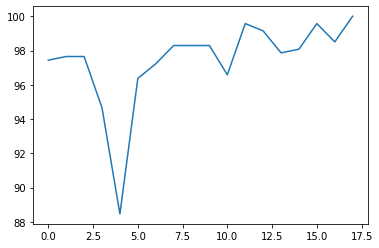

100.0
17


In [113]:

accuracy_each_epochs = []

input_nodes = 105
output_nodes = 4
bias = 1

learning_rate = 0.1


###

n = neuralNetwork(input_nodes,output_nodes,learning_rate,bias)




epochs = 2500
for e in range(epochs):
    
    for i in range(len(train_list)):
        inputs =  train_list[i]        
        targets = train_list_ans[i]
        n.train(inputs, targets)
        pass
    pass

    #test
    
    scorecard = []

    # go through all the records in the test data set
    for  i in range(len(test_list)):
        inputs =  test_list[i]
        ans = test_list_ans[i]
      
               
        outputs = n.query(inputs)
        
        # the index of the highest value corresponds to the label
        label = np.argmax(outputs)
        
        # append correct or incorrect to list
        if (label == ans):
            
            scorecard.append(1)
        else:
            # network's answer doesn't match correct answer, add 0 to scorecard
            scorecard.append(0)
            pass
        pass
    # calculate the performance score, the fraction of correct answers
    scorecard_array = np.asarray(scorecard)
    #print ("performance = ", scorecard_array.sum() /scorecard_array.size*100)
    accuracy_each_epochs.append(scorecard_array.sum() /scorecard_array.size*100)
    if(scorecard_array.sum() /scorecard_array.size*100 == 100):
      break

plt.plot(np.arange(len(accuracy_each_epochs)),np.array(accuracy_each_epochs)) 
plt.show()
print(max(accuracy_each_epochs))
print(np.argmax(accuracy_each_epochs))

In [114]:
fail_num = 1
scorecard = []
for  i in range(len(test_after_train_list)):
    inputs =  test_after_train_list[i]
    ans = test_after_train_list_ans[i]
  
            
    outputs = n.query(inputs)
    
    # the index of the highest value corresponds to the label
    label = np.argmax(outputs)
    
    # append correct or incorrect to list
    if (label == ans):
        
        scorecard.append(1)
    else:
        # network's answer doesn't match correct answer, add 0 to scorecard
        scorecard.append(0)
        
        print(fail_num,' ',ans,' ',np.transpose(outputs))
        fail_num+=1
        pass
    pass
# calculate the performance score, the fraction of correct answers
scorecard_array = np.asarray(scorecard)
print ("performance = ", scorecard_array.sum() /scorecard_array.size*100)

1   2   [[0. 0. 0. 0.]]
2   2   [[0. 0. 0. 0.]]
3   2   [[0. 0. 0. 0.]]
4   2   [[0. 0. 0. 0.]]
5   2   [[0. 0. 0. 0.]]
6   2   [[0. 0. 0. 0.]]
performance =  96.15384615384616


In [34]:
#train_list

In [35]:
#train_list_ans

Text(0.5, 0, 'b')

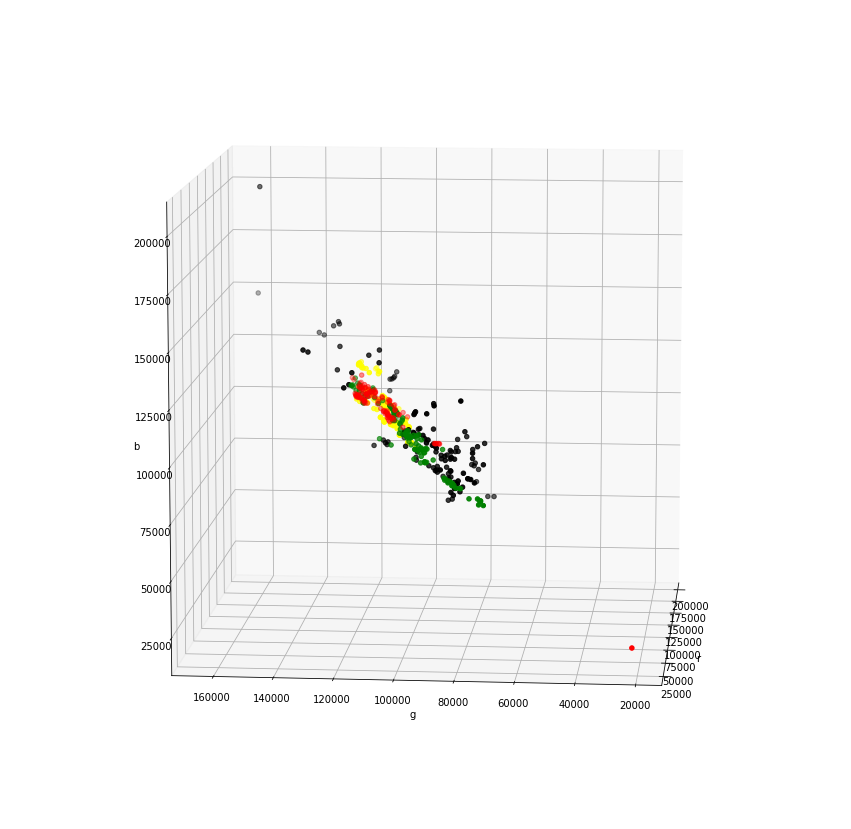

In [36]:
# xdata = 7 * np.random.random(100)
# ydata = np.sin(xdata) + 0.25 * np.random.random(100)
# zdata = np.cos(xdata) + 0.25 * np.random.random(100)
x1=[]
y1=[]
z1= []
x2=[]
y2=[]
z2= []
x3=[]
y3=[]
z3= []
x4=[]
y4=[]
z4= []
for i in range(len(train_list)):
    if (np.argmax(train_list_ans[i]) == 0):
        x1.append(train_list[i][0])
        y1.append(train_list[i][1])
        z1.append(train_list[i][2])
    elif (np.argmax(train_list_ans[i]) == 1):
        x2.append(train_list[i][0])
        y2.append(train_list[i][1])
        z2.append(train_list[i][2])
    elif (np.argmax(train_list_ans[i]) == 2):
        x3.append(train_list[i][0])
        y3.append(train_list[i][1])
        z3.append(train_list[i][2])
    else:
        x4.append(train_list[i][0])
        y4.append(train_list[i][1])
        z4.append(train_list[i][2])


fig = plt.figure(figsize=(15, 15))
# Create 3D container
ax = plt.axes(projection = '3d')
# Visualize 3D scatter plot
ax.scatter3D(x1,y1,z1,color="g")
ax.scatter3D(x2,y2,z2,color="black")
ax.scatter3D(x3,y3,z3,color="red")
ax.scatter3D(x4,y4,z4,color="yellow")

ax.view_init(10, 185)
# Give labels
ax.set_xlabel('r')
ax.set_ylabel('g')
ax.set_zlabel('b')
# Save figure
#plt.savefig('3d_scatter.png', dpi = 300);